<img src="../../img/ods_stickers.jpg">

## Открытый курс по машинному обучению
Автор материала: Шахова Нонна - @nonna


# Python R Collaboration
### life hacking

Не знаю как вы, но я постоянно встречаю сравнение R и Python в задачах работы с данными и машинного обучения. Я бы даже сказала, их противопоставление и выяснение, какой же лучше? Вы можете найти массу исследований, рассматривающих практически все аспекты работы с тем и другим, но вряд ли где-то есть ответ: "Используй один из двух и все будет OK вообще всегда!" Скорее вы встретите что-то вроде: "Для этой конкретной задачи лучше использовать R, а для той, конечно, Python" - и тут не только в самой задаче дело. Очевидно, что все зависит от конечной цели. Нужно глубокое научное исследование? Бери R, там есть все для этого. Хочешь, чтоб работало быстро и в продакшене? Возьми лучше Python, потом спасибо скажешь! И так до бесконечности...

<img src="../../img/RPy.jpg">

Предположим, у нас все написано на R либо Python: все хорошо работает и проблем не приносит. Но вдруг возникла гениальная мысль, которую хочется срочно проверить, а подходящего пакета нет?!

Для этого существуют пакеты несколько способов взять все лучшее из Python и R и собрать своего Франкинштейна. Данный туториал будет об одном из таких способов решения самых тривиальных задач, с которыми вы сталкивались или обязательно повстречаетесь в будущем:


>- Как определить число кластеров и не ошибиться?
>- Как представить в 2D на данные с большим количеством признаков и не потерять суть?

Прежде чем начать работу:

1 способ: Если вы не используете докер:
    - поставьте R под вашу систему (OS X, Win, Ubu): https://www.r-project.org 
    - поставьте rpy2: conda install rpy2
    - остальные R пакеты потренируемся ставить из jupyter notebook
    
   
2 способ: Если вы используете докер-контейнер:
    - придется поставить R в контейнер и собрать образ снова (т.к. лозунг этого туториала "по-быстренькому", если вы новичок, который ранее не собирал контейнеры, следуйте первому варианту)

In [1]:
from sklearn import datasets
import pandas as pd

import rpy2.interactive as r
import rpy2.interactive.packages

from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

rlib = r.packages.packages
r.packages.importr("utils")

rpy2.robjects.packages.Package as a <module 'utils'>

## Лафхак 1: подбираем число кластеров

Предположим, что мы исследуем вопрос об оптимальном количестве кластеров для какого-либо датасета. Общеизвестное правило локтя покажет нам такую картину:

<img src="../../img/Noclast.png">

По такому графику сложно сказать уверенно, какое же количество кластеров будет лучшим. Кто-то скажет 2, кто-то 4 - крайне субъективная оценка... И тут на помощь приходит мудрость толпы - устроим голосование!

Для этого используем 30 показателей оптимального количества кластеров R пакета NbClust: https://cran.r-project.org/web/packages/NbClust/NbClust.pdf

Populating the interactive namespace from numpy and matplotlib


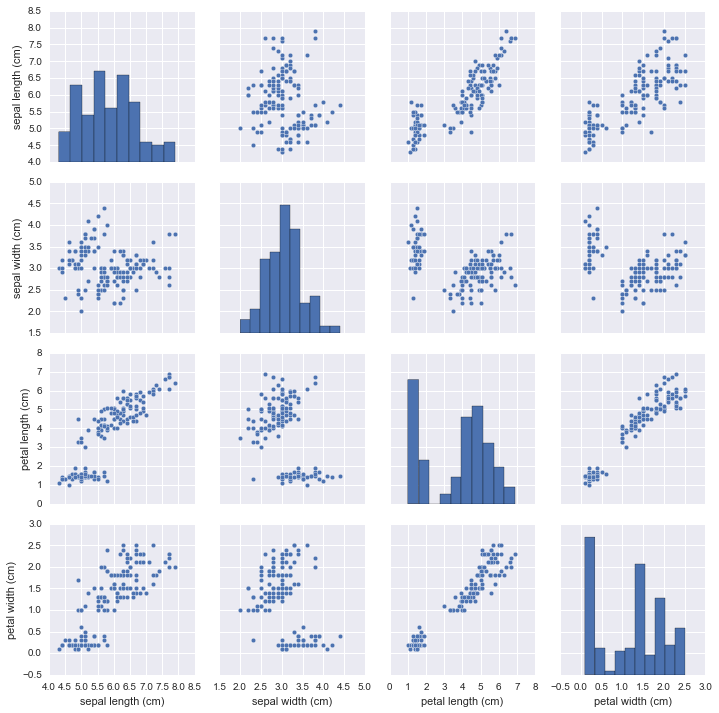

In [2]:
# Для примера возьмем всем хорошо знакомый датасет Iris

iris = datasets.load_iris()
df = pd.DataFrame(data = iris.data, columns = iris.feature_names)

features = df.columns
df['target'] = iris.target
import seaborn as sns
%pylab inline

sns.pairplot(df[features]);

Визуально можно выделить два класса, но мы подозреваем, что их больше, так сколько же?

In [3]:
# преобразуем его в R-пригодный вид
r_df = pandas2ri.py2ri(df[features])

# и отправим в R
%Rpush r_df 

# теперь пришло время поставить в R пакет NbClust, сделать это можно так
rlib.utils.install_packages("NbClust");

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 3 proposed 2 as the best number of clusters 
* 12 proposed 3 as the best number of clusters 
* 5 proposed 4 as the best number of clusters 
* 1 proposed 6 as the best number of clusters 
* 2 proposed 10 as the best numbe

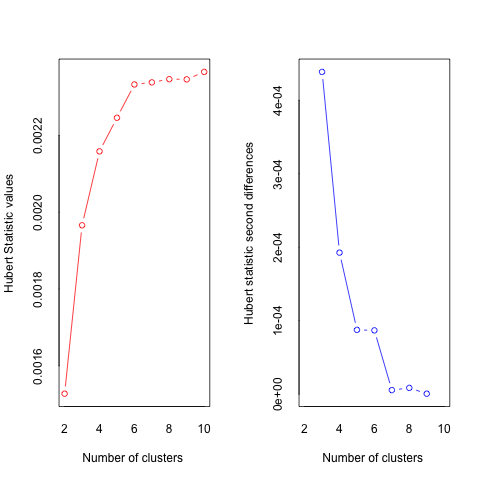

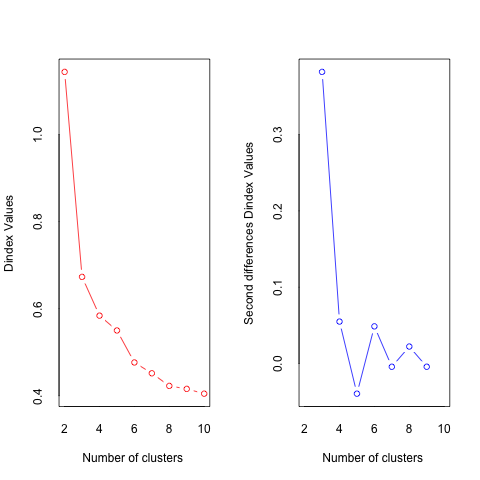

In [4]:
# а теперь начинается магия!

# подключаем библиотеку
%R library(NbClust)

# сид для воспроизводимости
%R set.seed(1234)

# и указываем диапазон от 2 до 10 кластеров
%R Nnc <- NbClust(r_df, distance = "euclidean", min.nc = 2, max.nc = 10, method = "complete", index = "all")

Цитируя Conclusion: ...the best number of clusters is  3! 

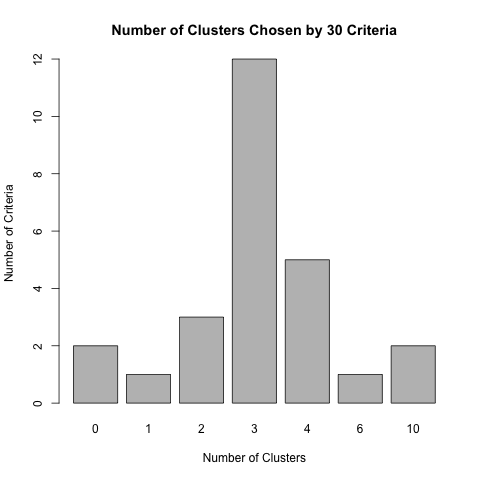

In [5]:
# интересно посмотреть как распределились голоса
%R table(Nnc$Best.n[1,])
%R barplot(table(Nnc$Best.n[1,]), xlab="Number of Clusters", ylab="Number of Criteria", main="Number of Clusters Chosen by 30 Criteria");

Выглядит очень убедительно, давайте посмотрим на данные в привычном виде - нет ли явных противоречий?

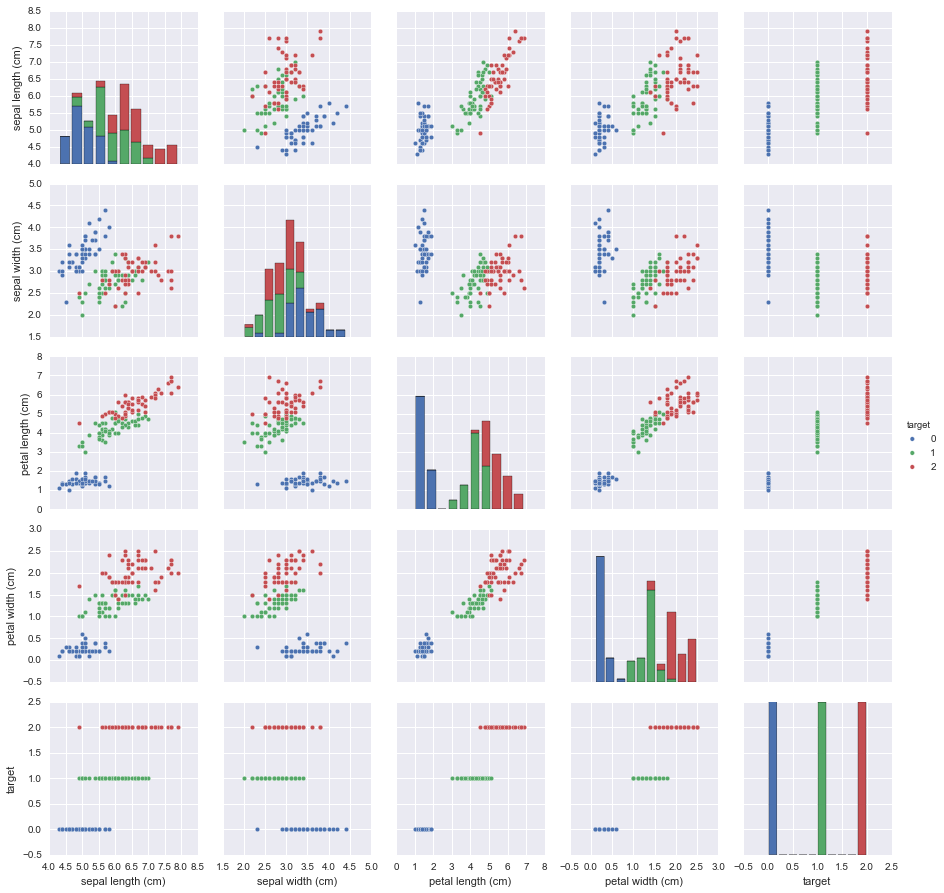

In [6]:
sns.pairplot(df, hue = 'target');

Очевидно, что данные вполне хорошо разделимы на три кластера, как и выяснилось с помощью NbClust.

На самом деле, из этого пакета можно вытащить намного больше полезной информации, особенно это может быть полезно в Research работах.

## Лафхак 2: организуем самоорганизующуюся карту Кохонена за 5 мин

В двух словах, самоорганизующиеся карты Кохонена славятся тем, что делают 2D представление из многомерного(и даже очень) представления с минимумом потерь смысла, а еще они самообучаются. R-пакет kohonen обладает массой полезных инструментов, например, heatmaps и разрезы по каждому признаку. А также это очень красиво!

https://cran.r-project.org/web/packages/kohonen/kohonen.pdf

В данном примере возьмем датасет побольше: Boston data (недвижимость). В данном случае, мы не решаем задачу кластеризации, но хотим использовать аггрегирование данных как дополнительную feature. 

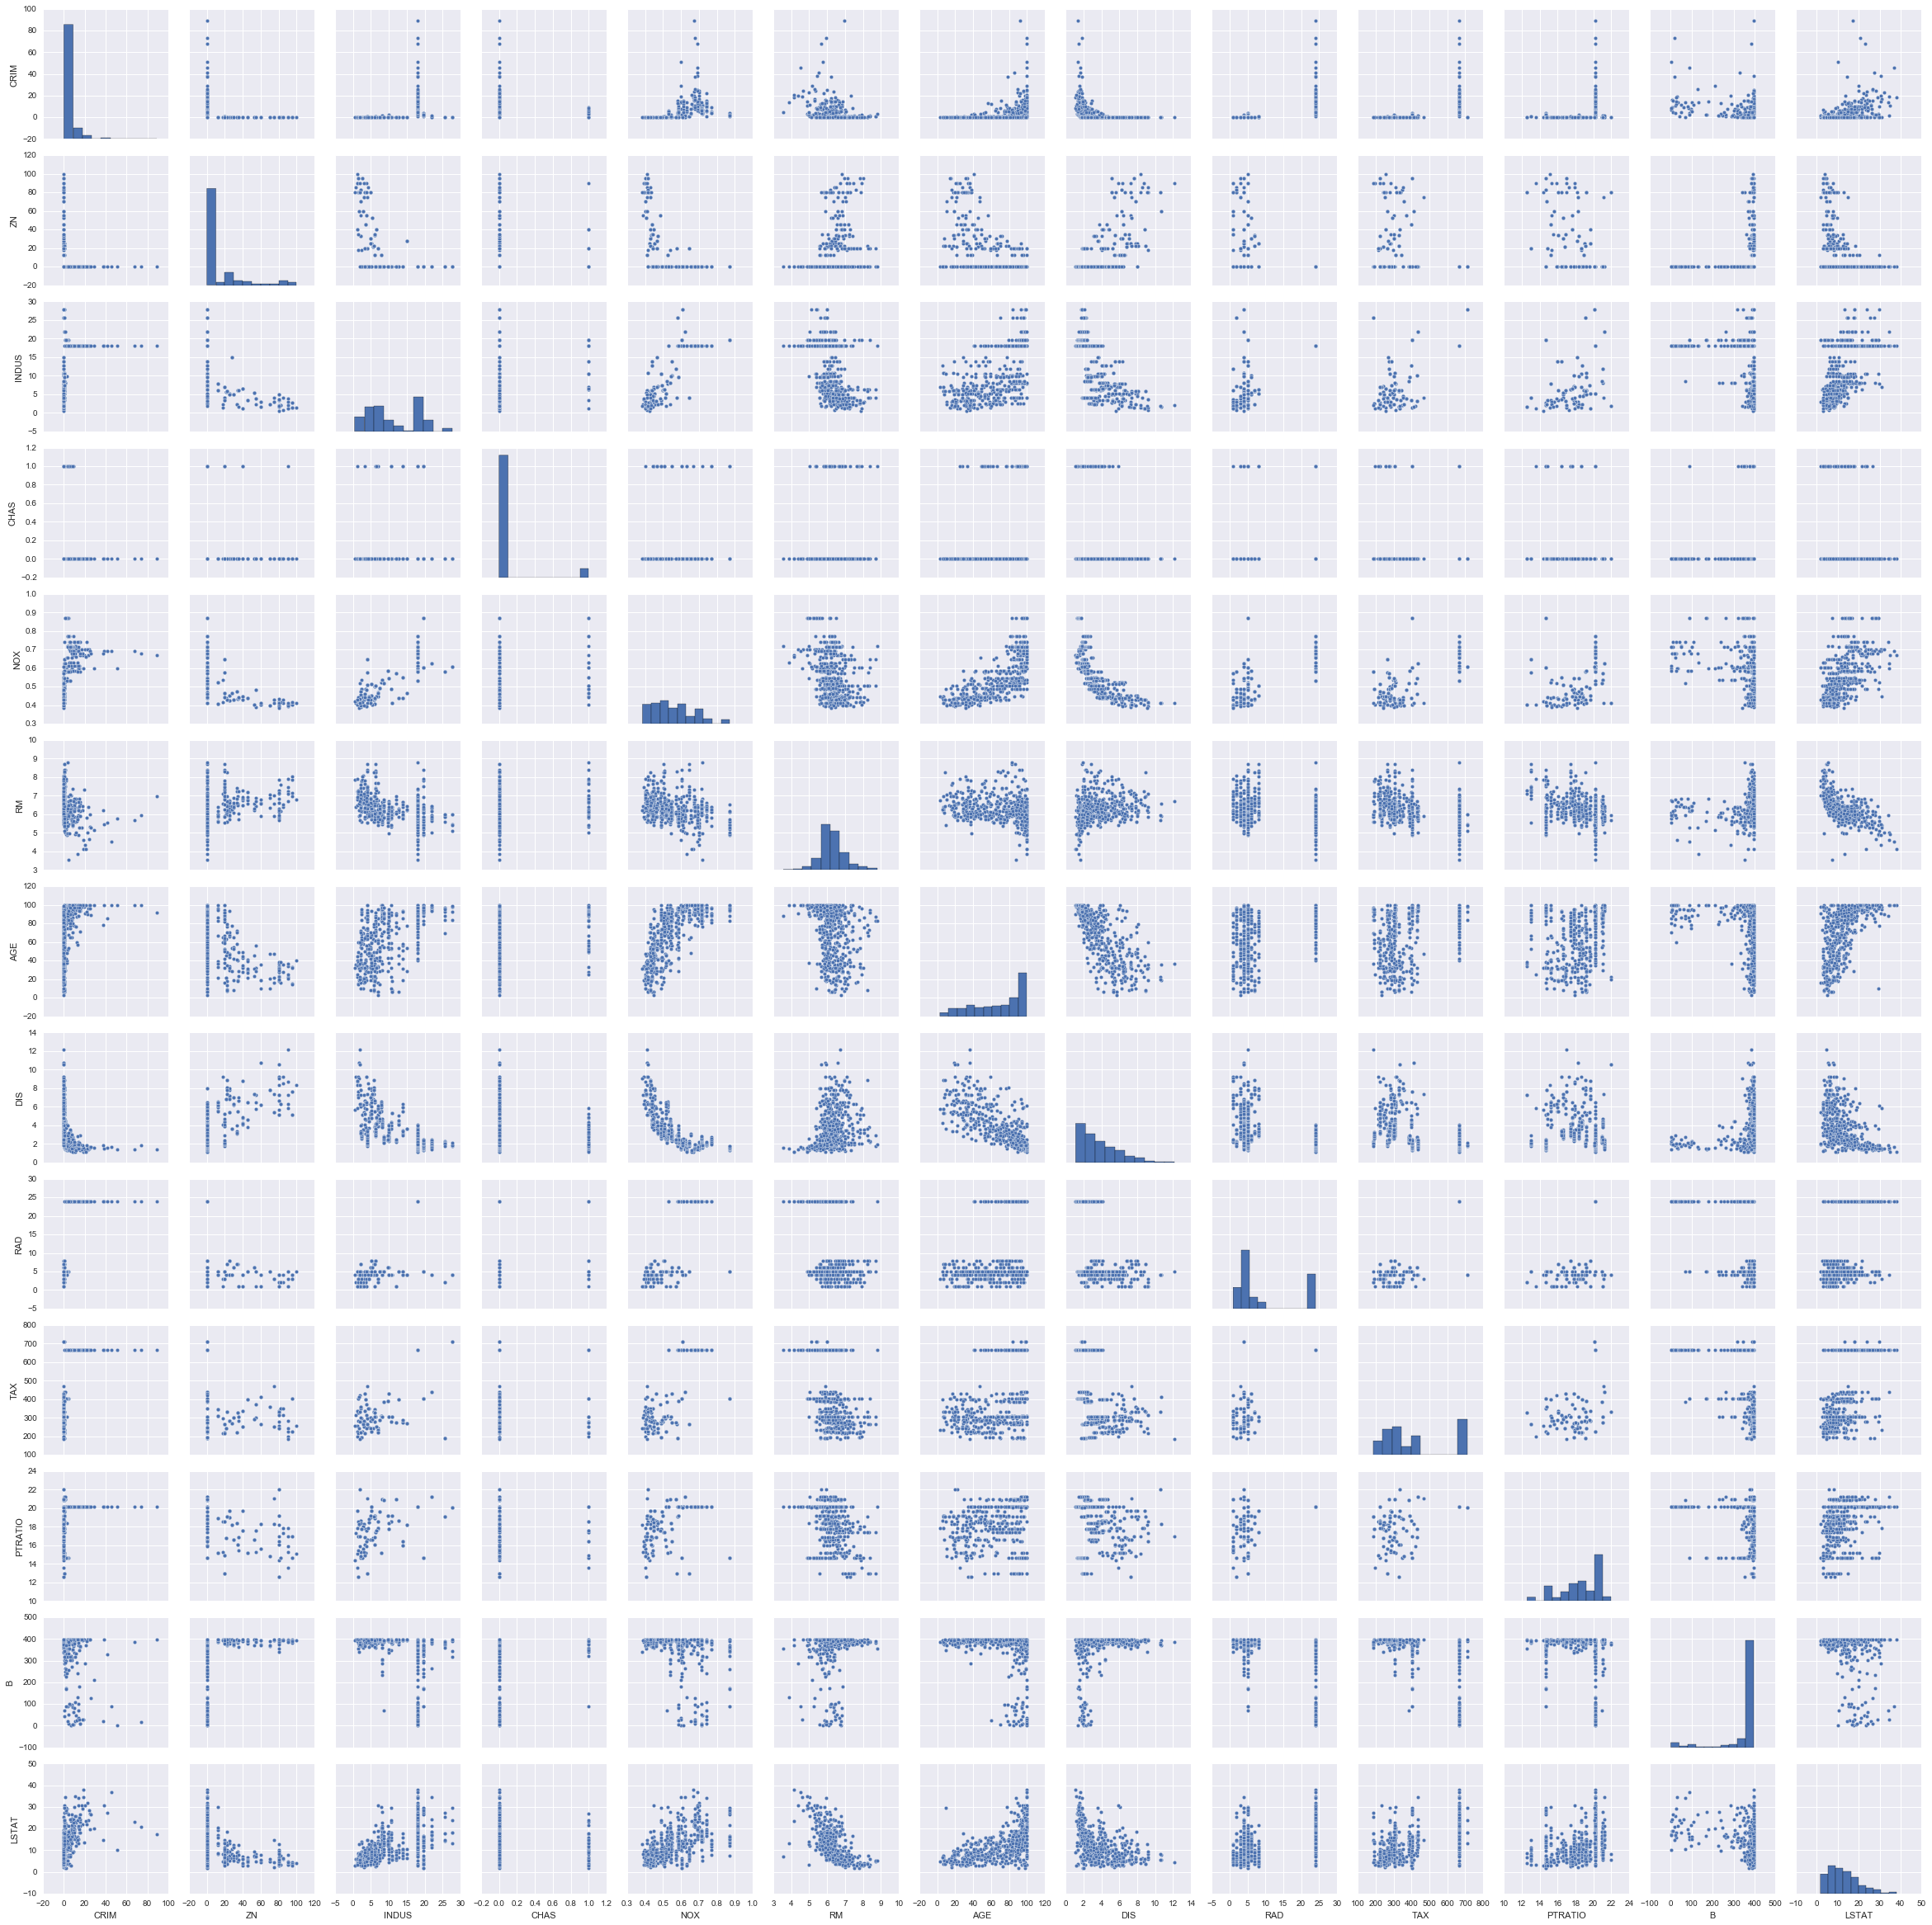

In [7]:
boston = datasets.load_boston()
b_df = pd.DataFrame(data = boston.data, columns = boston.feature_names)

br_df = pandas2ri.py2ri(b_df)
sns.pairplot(b_df);

In [8]:
# поставим в R пакет kohonen
rlib.utils.install_packages("kohonen")

In [9]:
%Rpush br_df 

%R library(kohonen)
%R set.seed(1234)

# данные нужно отдать в виде матрицы
%R b_matrix <- as.matrix(br_df)
%R som_grid <- somgrid(xdim = 20, ydim=20, topo="hexagonal")

# и организовать карту
%R bos.som <- som(b_matrix, som_grid, rlen=100, alpha=c(0.05,0.01));

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 6 proposed 2 as the best number of clusters 
* 7 proposed 3 as the best number of clusters 
* 3 proposed 4 as the best number of clusters 
* 2 proposed 7 as the best number of clusters 
* 4 proposed 8 as the best number 

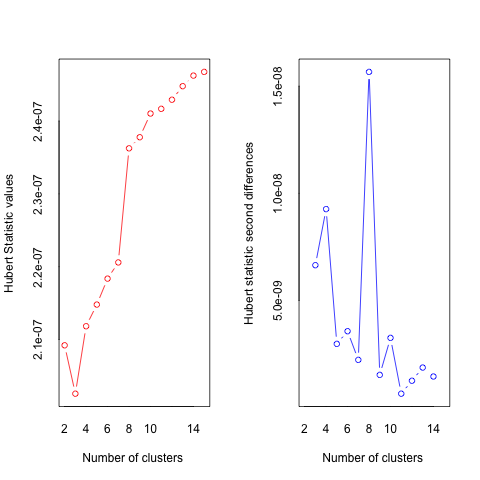

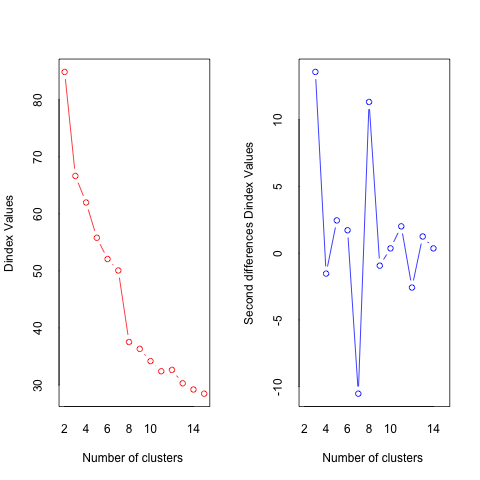

In [10]:
# теперь определим количество кластеров уже известным нам трюком
%R codes <- getCodes(bos.som)
%R b_Nnc <- NbClust(codes, min.nc=2, max.nc=15, method="kmeans");

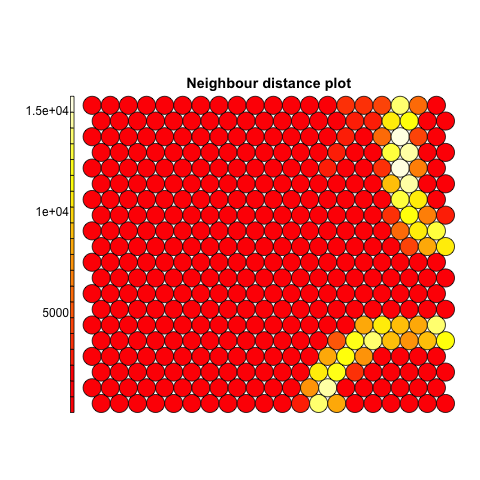

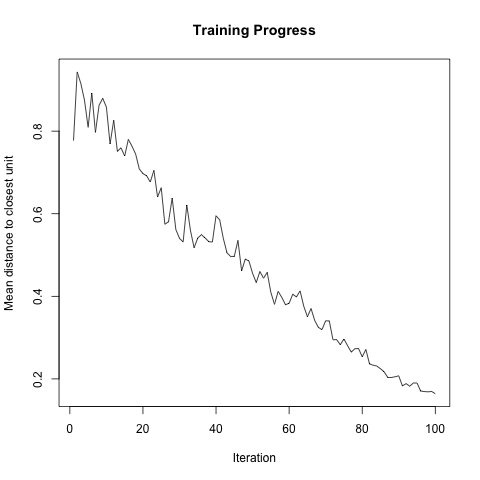

In [11]:
# и посмотрим на некоторые визуализации
%R plot(bos.som, type="dist.neighbours")
%R plot(bos.som, type="changes",main="Training Progress")

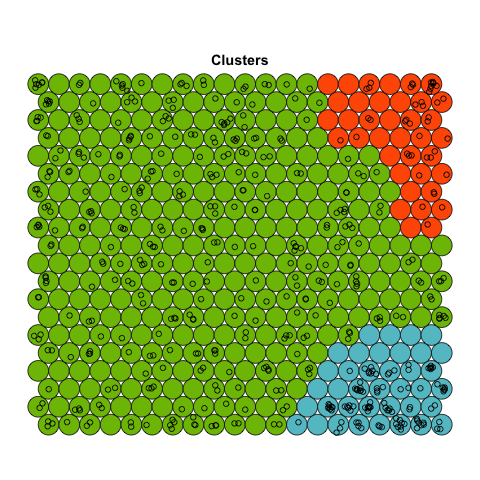

In [12]:
# в конечном итоге, вот так выглядит в двумерном пространстве весь датасет
%R som_cluster <- cutree(hclust(dist(codes)), 3)
%R pretty_palette <- c('#7DBD00', '#62C2CC', '#FF5B00', '#f1bc41')
%R plot(bos.som, type='mapping', bgcol = pretty_palette[som_cluster], main = "Clusters") 

Если немного поколдовать над визуальной составляющей, то можно получать более приятные изображения, например:
<img src="../../img/NCl.png">
Подводя итог, хочется отметить, что самоорганизующиеся карты удобный, понятный, но незаслуженно обойденный питоном инструмент. Я пробовала, наверное, все реализации этого пакета для питона, но они существенно уступают R. Конечно, карты Кохонена будут использоваться не каждый день, но, согласитесь, это очень удобно: запихать туда весь датафрейм, оценить, насколько четкая или нет идет кластеризация и принять решение, имеет ли смысл вводить такой признак или сэкономить время для другой полезной работы.

## Что осталось за кадром

Эти два крошечных примера не могут показать всех преимуществ использования R и Python, а они все больше становятся взаимопомогающими, а не противоборствующими. Можно привести пример в той же ARIMA, которая настолько прекрасна в R, что переписывать ее на Python нет большого смысла. Ведь к ней также можно обращаться, особенно для подбора p, d, q, P, D, Q:
> %R model_lam = forecast::auto.arima(ts_a, stepwise = TRUE, lambda = ll)

https://cran.r-project.org/web/packages/forecast/forecast.pdf

А также выделить тренд из STL (который часто бывает полезной feature)
> %R trendSTL = stl$time.series

https://cran.r-project.org/web/packages/stlplus/stlplus.pdf

Все это очень удобно для первого приближения к желаемой модели, т.к. где-то в идеальном мире мы не используем пакеты из коробки, а детально разбираемся в том, как каждый из них работает ;)